<a href="https://colab.research.google.com/github/Malvez/Trabalhos_RN/blob/main/Redes_Neurais_Trabalho_2_Classificar_o_MNIST_original_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
# Função para carregar os dados do MNIST
def load_mnist(path, kind='train'):
    labels_path = os.path.join(path, f'{kind}-labels.idx1-ubyte')
    images_path = os.path.join(path, f'{kind}-images.idx3-ubyte')

    with open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 28, 28)

    return images, labels

# Carregar os dados
train_images, train_labels = load_mnist('/home/mnist_dataset', kind='train')
test_images, test_labels = load_mnist('/home/mnist_dataset', kind='t10k')

# Preprocessamento dos dados
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

# Adicionar um eixo para o canal de cor
train_images = np.expand_dims(train_images, -1)
test_images = np.expand_dims(test_images, -1)

# Converter labels para one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

In [4]:
# Função para criar pesos e bias
def create_weights(shape):
    return tf.Variable(tf.random.truncated_normal(shape, stddev=0.1))

def create_bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape))

# Função para convolução
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# Função para max pooling
def max_pool_2x2(x):
    return tf.nn.max_pool2d(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Construir o modelo
class CNNModel(tf.Module):
    def __init__(self):
        self.W_conv1 = create_weights([3, 3, 1, 32])
        self.b_conv1 = create_bias([32])

        self.W_conv2 = create_weights([3, 3, 32, 64])
        self.b_conv2 = create_bias([64])

        self.W_conv3 = create_weights([3, 3, 64, 64])
        self.b_conv3 = create_bias([64])

        self.W_fc1 = create_weights([7 * 7 * 64, 64])
        self.b_fc1 = create_bias([64])

        self.W_fc2 = create_weights([64, 10])
        self.b_fc2 = create_bias([10])

    def __call__(self, x):
        h_conv1 = tf.nn.relu(conv2d(x, self.W_conv1) + self.b_conv1)
        h_pool1 = max_pool_2x2(h_conv1)

        h_conv2 = tf.nn.relu(conv2d(h_pool1, self.W_conv2) + self.b_conv2)
        h_pool2 = max_pool_2x2(h_conv2)

        h_conv3 = tf.nn.relu(conv2d(h_pool2, self.W_conv3) + self.b_conv3)

        h_pool2_flat = tf.reshape(h_conv3, [-1, 7 * 7 * 64])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, self.W_fc1) + self.b_fc1)

        logits = tf.matmul(h_fc1, self.W_fc2) + self.b_fc2
        return logits

# Definir a função de perda e otimizador
def compute_loss(logits, labels):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))

def compute_accuracy(logits, labels):
    predictions = tf.argmax(logits, axis=1)
    correct_labels = tf.argmax(labels, axis=1)
    return tf.reduce_mean(tf.cast(tf.equal(predictions, correct_labels), tf.float32))

# Treinar o modelo
def train_step(model, images, labels, optimizer):
    with tf.GradientTape() as tape:
        logits = model(images)
        loss = compute_loss(logits, labels)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [5]:
# Inicializar o modelo e otimizador
model = CNNModel()
optimizer = tf.optimizers.Adam(1e-4)

# Treinar o modelo
num_epochs = 5
batch_size = 50
num_batches = len(train_images) // batch_size

for epoch in range(num_epochs):
    for i in range(num_batches):
        batch_start = i * batch_size
        batch_end = batch_start + batch_size
        batch_images = train_images[batch_start:batch_end]
        batch_labels = train_labels[batch_start:batch_end]

        loss = train_step(model, batch_images, batch_labels, optimizer)

        if i % 300 == 0:
            train_accuracy = compute_accuracy(model(batch_images), batch_labels)
            print(f'Epoch {epoch}, step {i}, training accuracy {train_accuracy.numpy()}, loss {loss.numpy()}')


Epoch 0, step 0, training accuracy 0.14000000059604645, loss 2.8436102867126465
Epoch 0, step 300, training accuracy 0.8799999952316284, loss 0.40791618824005127
Epoch 0, step 600, training accuracy 0.8399999737739563, loss 0.38867324590682983
Epoch 0, step 900, training accuracy 0.8999999761581421, loss 0.43075019121170044
Epoch 1, step 0, training accuracy 0.9800000190734863, loss 0.1682339608669281
Epoch 1, step 300, training accuracy 0.9800000190734863, loss 0.10050760209560394
Epoch 1, step 600, training accuracy 0.9599999785423279, loss 0.18542392551898956
Epoch 1, step 900, training accuracy 0.9399999976158142, loss 0.1825622022151947
Epoch 2, step 0, training accuracy 0.9800000190734863, loss 0.07748088985681534
Epoch 2, step 300, training accuracy 0.9800000190734863, loss 0.05206938832998276
Epoch 2, step 600, training accuracy 0.9599999785423279, loss 0.1548823118209839
Epoch 2, step 900, training accuracy 0.9800000190734863, loss 0.08367803692817688
Epoch 3, step 0, training

In [6]:
# Avaliar o modelo nos dados de teste
test_logits = model(test_images)
test_accuracy = compute_accuracy(test_logits, test_labels)
print('Test accuracy: ', test_accuracy.numpy())

Test accuracy:  0.9821


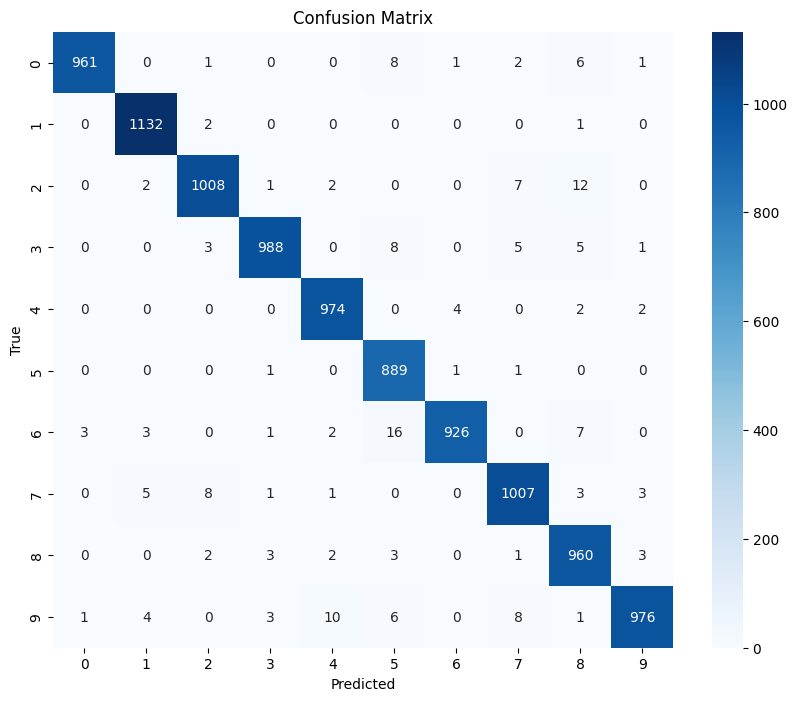

In [7]:
# Gerar previsões e calcular a matriz de confusão
test_predictions = tf.argmax(test_logits, axis=1)
true_labels = tf.argmax(test_labels, axis=1)
conf_matrix = confusion_matrix(true_labels, test_predictions)

# Plotar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()